In [5]:
from qiskit_nature.units import DistanceUnit # importos angstron para unidade
from qiskit_nature.second_q.drivers import PySCFDriver# Importamos o driver dee solução
from openfermion import FermionOperator, MolecularData
import pennylane as pnl
import numpy as np
import matplotlib.pyplot as plt

from qiskit_algorithms.minimum_eigensolvers import NumPyMinimumEigensolver
from qiskit_nature.second_q.algorithms import GroundStateEigensolver
from qiskit_nature.second_q.mappers import JordanWignerMapper

from qiskit_algorithms import VQE
from qiskit_algorithms.optimizers import SLSQP
from qiskit.primitives import Estimator
from qiskit_aer.primitives import Estimator as AerEstimator
from qiskit_aer.noise import NoiseModel
from qiskit_nature.second_q.circuit.library import HartreeFock, UCCSD
from qiskit_nature.units import DistanceUnit
from qiskit_nature.second_q.drivers import PySCFDriver
from qiskit_algorithms.minimum_eigensolvers import NumPyMinimumEigensolver
from qiskit_nature.second_q.algorithms import GroundStateEigensolver
from qiskit_nature.second_q.mappers import JordanWignerMapper
from qiskit_nature.second_q import *
from qiskit_nature.units import DistanceUnit # importos angstron para unidade
from qiskit_nature.second_q.drivers import PySCFDriver# Importamos o driver dee solução
from openfermion import FermionOperator, MolecularData
from qiskit_algorithms.minimum_eigensolvers import NumPyMinimumEigensolver
from qiskit_nature.second_q.algorithms import GroundStateEigensolver
from qiskit_nature.second_q.mappers import JordanWignerMapper, BravyiKitaevMapper
import scienceplots



In [2]:
solver = GroundStateEigensolver(
    JordanWignerMapper(),
    NumPyMinimumEigensolver())

In [3]:
dados_qiskit = []
distancia = np.arange(0.2,3,0.1)

#Fazendo o loop para passar por diversas distâncias
for i in distancia:

# Criando o sistema do problema.
  energy = PySCFDriver(
      atom=f"H 0 0 0; H 0 0 {i}",
      basis="sto3g",
      charge=0,
      spin=0,
      unit=DistanceUnit.ANGSTROM)
  
#rodando e resolvendo ele
  problema = energy.run()
  resultado = solver.solve(problema)

#Armazenando o daddos
  dados_qiskit.append(resultado.groundenergy + resultado.nuclear_repulsion_energy)

### Cirq

In [9]:
basis = 'sto-3g' #escolha de base
multiplicity = 1 #....... Pesquisar: relacionado com possiveis geometrias da molécula?


dados_cirq_fci = [] #armazenar os dados
dados_cirq_hf = []

# criando o loop pelos potnos de distância
for point in distancia:
    description = str(round(point,2)) #tentar entender como funciona o discription
    geometry = [('H', (0., 0., 0.)), ('H', (0., 0., point))] #tipo de molécula e suas posições euclidianas
    molecule = MolecularData( geometry, basis, multiplicity, description = description) #crriando a molécula

    molecule.load() #...... o que sinifica carregar ?

#armazenando todos os dados para HF e FCI
    dados_cirq_fci.append(molecule.fci_energy)
    dados_cirq_hf.append(molecule.hf_energy)


### PennyLane


In [18]:
len(np.arange(0.2,3,0.1))


28

In [20]:
len(np.arange(0.2,5.8,0.2))

28

In [21]:
#criando um espaço de HF
hf = pnl.qchem.hf_state(2,4)

#designando os átomos
molecules = ["H", 'H']

#armazenar os dados de energia
dados_pennylane = []

#criando o intevalo de distâncias
intervalo = np.arange(0.2,5.8,0.2)

#rodando sobre o intervalo
for i in intervalo:

  #coordenadas
  coord = np.array([[0.0,0.0,0.0],[0.0,0.0,i]])

  #criando a hamiltoniana
  H, qubits = pnl.qchem.molecular_hamiltonian(molecules, coord, method = 'pyscf')

  #maquina e otimizador
  maq = pnl.device("default.qubit", wires = qubits)
  opt = pnl.GradientDescentOptimizer(0.4)

  @pnl.qnode(maq, interface='autograd')
  def circuit(parameters):
      # Prepare the HF state: |1100>
      pnl.BasisState(hf, wires=range(qubits))
      pnl.DoubleExcitation(parameters[0], wires=[0, 1, 2, 3])
      pnl.SingleExcitation(parameters[1], wires=[0, 2])
      pnl.SingleExcitation(parameters[2], wires=[1, 3])

      return pnl.expval(H)  # we are interested in minimizing this expectation value

  # parametro de otimização
  params = np.zeros(3)

  #trackers
  pontos = 0
  energia_previa = 0

  # fazendo uma atualização de parametros
  if pontos > 0:
      params = params_old

  #fazendo otimizações para cada distância segundo os paramêtros
  for n in range(50):

      # perform optimization step
      params, energia = opt.step_and_cost(circuit, params)

      #certificando a convergÇencia
      if np.abs(energia - energia_previa) < 1e-6:
          break

      #atualização do valor de energia
      energia_previa = energia

  # guardando os parametros depois da otimização e convergência
  params_old = params
  pontos =+ 1

  #salvando a nergia depois de toda otimização
  dados_pennylane.append(energia)

/home/bandeira/.local/lib/python3.10/site-packages/pennylane/_grad.py:158: UserWarning: Attempted to differentiate a function with no trainable parameters. If this is unintended, please add trainable parameters via the 'requires_grad' attribute or 'argnum' keyword.
  warnings.warn(


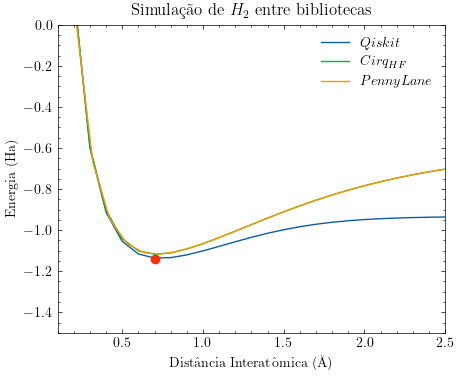

In [50]:
import matplotlib.pyplot as plt
plt.style.use('science')

a = plt.figure()
a.set_figwidth(5)
a.set_figheight(4)

plt.xlim(0.1,2.5)
plt.ylim(-1.5,0)

plt.plot(distancia, dados_qiskit, label = '$Qiskit$')
plt.plot(distancia, dados_cirq_hf, label = '$Cirq_{HF}$')
plt.plot(np.array(intervalo)*0.529177249, dados_pennylane, label =  '$PennyLane$')
plt.plot(0.7,-1.14, 'o')

plt.title('Simulação de $H_2$ entre bibliotecas')
plt.xlabel('Distância Interatômica (Å)')
plt.ylabel('Energia (Ha)')

plt.legend()
plt.show()

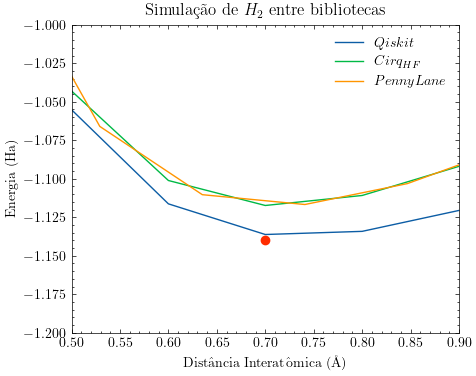

In [51]:
plt.style.use('science')

a = plt.figure()
a.set_figwidth(5)
a.set_figheight(4)

plt.xlim(0.5,0.9)
plt.ylim(-1.2,-1)

plt.plot(distancia, dados_qiskit, label = '$Qiskit$')
plt.plot(distancia, dados_cirq_hf, label = '$Cirq_{HF}$')
plt.plot(np.array(intervalo)*0.529177249, dados_pennylane, label =  '$PennyLane$')
plt.plot(0.7,-1.14, 'o')

plt.title('Simulação de $H_2$ entre bibliotecas')
plt.xlabel('Distância Interatômica (Å)')
plt.ylabel('Energia (Ha)')

plt.legend()
plt.show()

In [54]:
import pandas as pd

data = {'distancia': distancia,
        'qiskit': dados_qiskit,
        'cirq_hf': dados_cirq_hf,
        'cirq_fci': dados_cirq_fci,
        'distancia_pennylane': np.array(intervalo)*0.529177249,
        'pennylane': dados_pennylane}

df = pd.DataFrame(data)
df.to_csv('Dados das energias das bibliotecas.csv',index=False)